In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from plotting import plot_utils
from model_fitting import initialize_fitting 
from utils import numpy_utils, default_paths, prf_utils
# from analyze_features import analyze_feature_decoding


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
counts_filename = os.path.join(default_paths.stim_labels_root, 'Highlevel_counts_all.npy')
counts = np.load(counts_filename, allow_pickle=True).item()

n_images = 50000

sub_ind = 9;
counts_categ = counts['counts_categ'][sub_ind,:,:]
categ_names = counts['categ_names']
n_categ = len(categ_names)

categ_names

['face',
 'building',
 'animate',
 'inanimate',
 'small',
 'large',
 'indoor',
 'outdoor']

In [3]:
np.any(np.isnan(counts_categ)), np.any(counts_categ==0)

(False, False)

In [4]:
which_prf_grid = 5;
models = prf_utils.get_prf_models(which_prf_grid)
n_prfs = len(models)

x = models[:,0]*8.4; y = models[:,1]*8.4;
ecc = np.round(np.sqrt(models[:,0]**2+models[:,1]**2)*8.4, 4)
sizes = np.round(models[:,2]*8.4, 4)
angles = np.round(np.mod(np.arctan2(y,x)*180/np.pi, 360),1)

ecc_vals = np.unique(ecc)
size_vals = np.unique(sizes)
ang_vals = np.unique(angles)
n_ecc = len(ecc_vals);
n_sizes = len(size_vals)
n_angles = len(ang_vals)

# take out the two largest eccentricities to make this comparable with the 
# decoding figure (same x-axes)
ecc_use = ecc_vals[0:8]
prfs_use = np.isin(ecc, ecc_use)

In [5]:
# choosing one size value to use when plotting effects of ecc, x, y
# (it's the smallest size value that was used for decoding)
sizes_use = [size_vals[5]]
sizes_use

[1.4763]

In [6]:
np.sum(prfs_use)

1280

In [7]:
import scipy
pars = [sizes, ecc, y, x]
n_pars = len(pars)
par_names = ['size', 'eccen','ypos', 'xpos']

categ_analyze = np.arange(6) # don't need to do this for indoor, outdoor
n_axes = len(categ_analyze)
names = np.array(categ_names)[categ_analyze]

n_iter = 10000
slope_values = np.zeros((n_axes, n_pars), dtype=float)
slope_values_shuffle = np.zeros((n_axes, n_pars, n_iter), dtype=float)

inter_values = np.zeros((n_axes, n_pars), dtype=float)
r_values = np.zeros((n_axes, n_pars), dtype=float)
p_values_parametric = np.zeros((n_axes,n_pars), dtype=float)

rndseed = 865767
np.random.seed(rndseed)

for ai in range(n_axes):

    for pi, par in enumerate(pars):
        
        print('%s counts, %s'%(names[ai], par_names[pi]))

        if pi==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]

        vals = counts_categ[prf_inds,ai]/n_images

        reg_result = scipy.stats.linregress(x_vals, vals)

        slope_values[ai,pi] = reg_result.slope
        inter_values[ai,pi] = reg_result.intercept
        r_values[ai,pi] = reg_result.rvalue
        p_values_parametric[ai,pi] = reg_result.pvalue

        # permutation test to get a non-parametric p-value
        for xx in range(n_iter):

            shuff_order = np.random.permutation(np.arange(len(x_vals)))
            shuff_x_vals = x_vals[shuff_order]
            reg_result = scipy.stats.linregress(shuff_x_vals, vals)
            slope_values_shuffle[ai,pi,xx] = reg_result.slope

face counts, size
face counts, eccen
face counts, ypos
face counts, xpos
building counts, size
building counts, eccen
building counts, ypos
building counts, xpos
animate counts, size
animate counts, eccen
animate counts, ypos
animate counts, xpos
inanimate counts, size
inanimate counts, eccen
inanimate counts, ypos
inanimate counts, xpos
small counts, size
small counts, eccen
small counts, ypos
small counts, xpos
large counts, size
large counts, eccen
large counts, ypos
large counts, xpos


In [13]:
import statsmodels
from utils import stats_utils

# compute a two-tailed p-value here:
p_values = np.minimum(np.mean(slope_values_shuffle<=slope_values[:,:,np.newaxis], axis=2), \
                      np.mean(slope_values_shuffle>=slope_values[:,:,np.newaxis], axis=2))*2
# FDR correction
mask_fdr, pvals_fdr = \
    stats_utils.fdr_keepshape(p_values, alpha=0.01)


In [14]:
p_values.shape

(6, 4)

In [15]:
par_names = ['size', 'eccen','ypos', 'xpos']

slopes_table = pd.DataFrame({}, index=names)
for pi in range(n_pars):
    slopes_table['%s slope'%par_names[pi]] = slope_values[:,pi]
    slopes_table['%s fdr sig'%par_names[pi]] = mask_fdr[:,pi]

slopes_table.iloc[0:6,:]

,size slope,size fdr sig,eccen slope,eccen fdr sig,ypos slope,ypos fdr sig,xpos slope,xpos fdr sig
face,0.041333,True,-0.038635,True,0.035420,True,-0.000092,False
building,0.021576,True,-0.010718,True,0.013867,True,-0.000082,False
animate,0.039977,True,-0.025217,True,-0.006778,True,-0.000171,False
inanimate,0.060012,True,-0.041046,True,-0.020902,True,-0.000349,False
small,0.054117,True,-0.040549,True,-0.013237,True,-0.000354,False
large,0.038211,True,-0.019554,True,-0.014539,True,-0.000098,False


In [16]:
colors = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

(-0.3, 8.9)
0 None
(-0.2, 4.2)
1 None
(-3.1, 3.1)
2 None
(-3.1, 3.1)
3 None


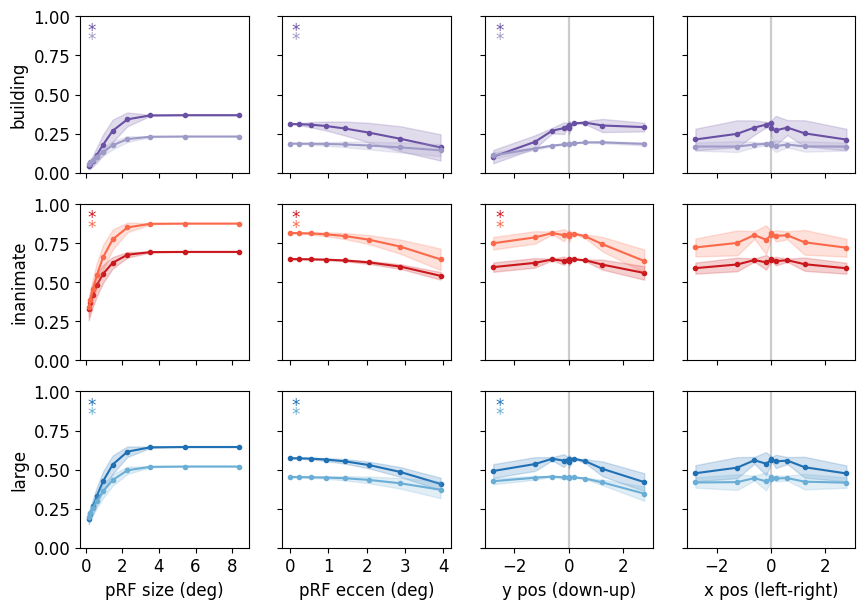

In [43]:
import scipy

sizes_use = [size_vals[5]]

plt.figure(figsize=(10,6.9));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

axes_plot = np.arange(8)

plot_inds = [(np.arange(4)+ii).astype(int) for ii in [1,1,5,5,9,9,13,13]]
plot_inds = np.array(plot_inds).ravel()

# npx = len(axes_plot)
npx = 3;

n_bins=10
linear_bins=False

# ylims = [0.48, 0.82];
ylims = [0, 1]
annot_ylocs = [0.82, 0.88]

yticks = np.linspace(0,1,5)

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]
xlims = [[-0.3,8.9],[-0.2, 4.2],[-3.1,3.1],[-3.1,3.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

annot_xlocs = [0.1,0.05,-2.7,-2.7]
    
pi=0;

axes_plot = np.arange(6)

for ai in axes_plot:

    name = names[ai]

    for par_ind, par in enumerate(pars):

        pi+=1
        plt.subplot(npx,4,plot_inds[pi-1])

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]
        vals = counts_categ[prf_inds,ai]/n_images

        # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
        if par_ind>1:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)  
        else:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai>3:
            plt.xlabel(par_names[par_ind])
            plt.xticks(xticks[par_ind])
        else:
            plt.xticks(xticks[par_ind], labels=[])
        if par_ind==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)
        plt.xlim(xlims[par_ind])

        # print(ai, par_ind)
        # print(mask_fdr[ai,par_ind])
        # rho, p = scipy.stats.pearsonr(x_vals, vals)
        # plt.title('rho=%.2f, p=%.4f'%(rho, p))
        if mask_fdr[ai, par_ind]:
            if np.mod(ai,2):
                annot_yloc=annot_ylocs[0]
            else:
                annot_yloc=annot_ylocs[1]
            plt.annotate('*',(annot_xlocs[par_ind],annot_yloc),color=colors[ai,:])

        if par_ind>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8])

        # plt.axhline(0.5, linestyle='--',color=[0.8, 0.8, 0.8, 1])
        if ai==0:
            print(par_ind, print(plt.gca().get_xlim()))
fn2save = fn2save = os.path.join(default_paths.fig_path,'counts_categ_all.pdf')
plt.savefig(fn2save)
